In [205]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')

In [206]:
def loadSingleFile( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(outputtype=pd.DataFrame,flatten=flatenndf)
    return data

## Prepare data files

In [207]:
### PREPARE DATA ####
RUN = 11813
PERIOD = "Run_3"

SHOW_TRACKS = False

PATH = "/exp/icarus/data/users/mvicenzi/pmt-calibration/track_matches/"
OUTPATH = "/exp/icarus/app/users/mvicenzi/pmt-calibration/cosmics-timing/residuals/output/" + PERIOD + "/"
COSMICSDB = "/exp/icarus/data/users/mvicenzi/timing-database/pmt_cosmics_timing_data/"
LASERDB = "/exp/icarus/data/users/mvicenzi/timing-database/pmt_laser_timing_data/"

FILENAME = PATH + "run{}_matched_light_tracks.root".format(RUN)

APPLY_LASER = False
LASERCORR = LASERDB + "pmt_laser_timing_data_run11590_from11641.csv"
APPLY_COSMICS = False
#COSMICSCORR = COSMICSDB + "pmt_cosmics_timing_data_run09773_from10085.csv"
COSMICSCORR = OUTPATH + "run11813_residuals_laseronly.csv"

suffix = "nocorr"
if APPLY_LASER:
    suffix = "laseronly"
if APPLY_LASER and APPLY_COSMICS:
    suffix = "lasercosmics"

OUTFILE = OUTPATH + "run{}_residuals_{}.csv".format(RUN,suffix)
    
print("Reading {}".format(FILENAME))

Reading /exp/icarus/data/users/mvicenzi/pmt-calibration/track_matches/run11813_matched_light_tracks.root


In [208]:
### Get optical data
dfw = loadSingleFile(FILENAME, "trackLightMatchW")
dfe = loadSingleFile(FILENAME, "trackLightMatchE")
df = pd.concat([dfe, dfw])
del dfw
del dfe

print("Considering {} track-flash matches".format( len(df) ) )

Considering 18631 track-flash matches


In [209]:
#df.head()

## Check tracks

In [210]:
if SHOW_TRACKS:

    fig, ax = plt.subplots(1,2, figsize=(12, 4.3),dpi=200)

    ax[0].plot( [df.track_end_z, df.track_start_z], [df.track_end_y, df.track_start_y], color='black', lw=0.1 )
    ax[0].axhline(y=125., linestyle="dashed")
    ax[0].axhline(y=-175., linestyle="dashed")

    ax[1].axvline(x=209., linestyle="dotted", color="C1", label="Cathode")
    ax[1].axvline(x=-209., linestyle="dotted", color="C1")
    ax[1].plot( [df.track_end_x, df.track_start_x], [df.track_end_y, df.track_start_y], color='black', lw=0.1 )
    ax[1].axhline(y=125., linestyle="dashed")
    ax[1].axhline(y=-175., linestyle="dashed")

    # consider steeper angles?
    #_sel_dir_z= (df.track_dir_z > -0.3) & (df.track_dir_z < 0.3 ) 
    #_sel_dir_x = (df.track_dir_X > -0.1) & (df.track_dir_x < 0.1 )
    #_seldir= _sel_dir_z
    #ax[0].plot( [dfmatches[_seldir].track_end_z, dfmatches[_seldir].track_start_z], [dfmatches[_seldir].track_end_y, dfmatches[_seldir].track_start_y], color='red', lw=0.1 )
    #ax[1].plot( [dfmatches[_seldir].track_end_x, dfmatches[_seldir].track_start_x], [dfmatches[_seldir].track_end_y, dfmatches[_seldir].track_start_y], color='red', lw=0.1 )
    #print( len(df), len(df[_seldir]) )

    ax[0].set_ylabel("Y [cm]" )  
    ax[0].set_xlabel("Z [cm]" )
    ax[0].grid(alpha=0.5)

    ax[1].set_ylabel("Y [cm]" )  
    ax[1].set_xlabel("X [cm]" ) 
    ax[1].grid(alpha=0.5)

    watermark = r'$\mathbf{ICARUS}\,$ Data' +' - Run {}'.format(RUN)
    ax[0].text(0.01, 1.05, watermark, fontsize=12, color='black', alpha=1,
         ha='left', va='center', transform=ax[0].transAxes)

    plt.legend()

    # save the image as pdf!
    savepath = "figs/tracks/run{}_tracks_standard_selection.pdf".format(RUN)
    print("Saving to {}...".format(savepath))
    plt.savefig(savepath,dpi=200)

    plt.show()

## Explode the dataframe

In [211]:
## Explode the dataframe 
df = df.explode(["pmt_time", "pmt_x", "pmt_y", "pmt_pe", "pmt_z", "pmt_amplitude","channel_id"])

## Add timing corrections (if needed!)

In [212]:
## Import and use laser correction
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT PREVIOUS STAGES
## note: laser corrections are in ns!

lasercorr = pd.read_csv(LASERCORR, sep=r'\s*,\s*', engine='python')
lasercorr = lasercorr.rename(columns={'channel': 'channel_id'})
lasercorr.set_index(["channel_id"])
lasercorr["t_signal"] = lasercorr["t_signal"]/1e3  #convert ns to us

df = df.join( lasercorr[["t_signal"]], on=["channel_id"])

if APPLY_LASER:
    print("Applying laser corrections from {}...".format(LASERCORR))
    df['pmt_time'] = df['pmt_time'] - df['t_signal']  #CURRENTLY ADDING LASER CORRECTIONS!

In [213]:
## Import and use cosmic corrections
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT PREVIOUS STAGES
## note: cosmics corrections are in ns!

cosmicscorr = pd.read_csv(COSMICSCORR, sep=r'\s*,\s*', engine='python')
cosmicscorr = cosmicscorr.rename(columns={'channel': 'channel_id'})
cosmicscorr.set_index(["channel_id"])
cosmicscorr["mean_residual_ns"] = cosmicscorr["mean_residual_ns"]/1e3  #convert ns to us

df = df.join( cosmicscorr[["mean_residual_ns"]], on=["channel_id"])

if APPLY_COSMICS:
    print("Applying cosmics corrections from {}...".format(COSMICSCORR))
    df['pmt_time'] = df['pmt_time'] - df['mean_residual_ns']  #CURRENTLY ADDING COSMICS CORRECTIONS!

In [214]:
df.loc[df["pmt_pe"]>100,["event","cryo","flash_id","pmt_y","channel_id","pmt_time",'t_signal','mean_residual_ns']]

,event,cryo,flash_id,pmt_y,channel_id,pmt_time,t_signal,mean_residual_ns
entry,,,,,,,,
0,15010,0,3,-129.050003,55,257.466305,0.193638,0.005883
0,15010,0,3,-23.450001,56,257.468483,0.192606,0.008541
0,15010,0,3,-76.25,58,257.466076,0.192635,-0.048497
0,15010,0,3,29.35,59,257.40921,0.195031,0.002128
0,15010,0,3,-76.25,60,257.464031,0.192582,0.007888
...,...,...,...,...,...,...,...,...
11809,12015,1,2,-76.25,320,-273.425781,0.196257,0.000192
11809,12015,1,2,29.35,321,-273.424866,0.192071,-0.000947
11809,12015,1,2,-129.050003,322,-273.429816,0.189732,0.000236


In [215]:
# drop unneed columns
df = df.drop(columns=["t_signal"])
df = df.drop(columns=["mean_residual_ns"])

## Computing fit and residuals

In [216]:
_pecut=300

_sel = (df.pmt_pe > _pecut)
meandf = df[_sel][["run", "event", "cryo", "flash_id", "pmt_time", "pmt_pe", "pmt_y"]].groupby(["run", "event", "cryo", "flash_id", "pmt_y"]).apply( 
    lambda x : pd.Series( {
        "mean_time" : np.mean(x.pmt_time),
        "weight_mean_time" : np.average(x.pmt_time, weights=x.pmt_pe), 
        "error_mean_time": np.std(x.pmt_time) / np.sqrt(len(x.pmt_time)),
    }) ).reset_index()

meandf = meandf.groupby(["run", "event", "cryo", "flash_id"]).agg(list)

print("PE cut leaves {} tracks".format( len(meandf) ))

PE cut leaves 16471 tracks


In [217]:
N = 4 # minimum number of quotas available for a good fit (at least 1 pmt >300 PE in each) 
meandf = meandf[meandf["pmt_y"].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) >= N)]

print("Minimum quotas cut leaves {} tracks".format( len(meandf ) ))

Minimum quotas cut leaves 10277 tracks


In [218]:
meandf.head()

pmt_y  \
run   event cryo flash_id                                                      
11813 12    1    11        [-129.0500030517578, -76.25, -23.4500007629394...   
      19    1    2         [-129.0500030517578, -76.25, -23.4500007629394...   
      27    1    17        [-76.25, -23.450000762939453, 29.3500003814697...   
      29    1    2         [-129.0500030517578, -76.25, -23.4500007629394...   
      30    0    1         [-129.0500030517578, -76.25, -23.4500007629394...   

                                                                   mean_time  \
run   event cryo flash_id                                                      
11813 12    1    11        [-537.9353872671875, -537.9353013664063, -537....   
      19    1    2         [-294.4277034273438, -294.4319181048828, -294....   
      27    1    17        [-634.5367999132812, -634.5368593917968, -634....   
      29    1    2         [106.00144156826173, 106.00298446689453, 106.0...   
      30    0    1         [-220.51806177089844, -220.52001177314452, -22...   

                                                            weight_mean_time  \
run   event cryo flash_id                                                      
11813 12    1    11        [-537.9353960808284, -537.9351495094909, -537....   
      19    1    2         [-294.4275906874389, -294.4331439010926, -294....   
      27    1    17        [-634.5367999132812, -634.5368335494065, -634....   
      29    1    2         [106.00144156826173, 106.00363786916603, 106.0...   
      30    0    1         [-220.51879960876258, -220.52050087790556, -22...   

                                                             error_mean_time  
run   event cryo flash_id                                                     
11813 12    1    11        [0.0007184376149326152, 0.0005896303807399834,...  
      19    1    2         [0.0010049727506396045, 0.0021174910565176334,...  
      27    1    17        [0.0, 0.001423212877232206, 0.0016117767111098...  
      29    1    2         [0.0, 0.0014530192234502633, 0.000540227094903...  
      30    0    1         [0.0014648384028142373, 0.0021689725043178474,...

In [219]:
def getdiff( y, t):
    # max y is on top : cosmics are going towards decreasing y 
    return t[np.argmin(y)] - t[np.argmax(y)]

def fittime( y, t ):
    try:
        res= stats.linregress(y, t)
        #print( res.intercept, res.slope)
        return res.intercept,  res.slope
    except:
        return 0,0

def residuals( tobs, y, a, b ):
    return tobs -  ( a + b*y )

In [220]:
meandf["diff_time"] = meandf.apply( lambda x : getdiff( x.pmt_y, x.mean_time ), axis=1 ) 
meandf[["intercept", "slope"]] = meandf.apply(lambda x : fittime(x.pmt_y, x.mean_time ), axis=1, result_type="expand" )

In [221]:
meandf.head()

pmt_y  \
run   event cryo flash_id                                                      
11813 12    1    11        [-129.0500030517578, -76.25, -23.4500007629394...   
      19    1    2         [-129.0500030517578, -76.25, -23.4500007629394...   
      27    1    17        [-76.25, -23.450000762939453, 29.3500003814697...   
      29    1    2         [-129.0500030517578, -76.25, -23.4500007629394...   
      30    0    1         [-129.0500030517578, -76.25, -23.4500007629394...   

                                                                   mean_time  \
run   event cryo flash_id                                                      
11813 12    1    11        [-537.9353872671875, -537.9353013664063, -537....   
      19    1    2         [-294.4277034273438, -294.4319181048828, -294....   
      27    1    17        [-634.5367999132812, -634.5368593917968, -634....   
      29    1    2         [106.00144156826173, 106.00298446689453, 106.0...   
      30    0    1         [-220.51806177089844, -220.52001177314452, -22...   

                                                            weight_mean_time  \
run   event cryo flash_id                                                      
11813 12    1    11        [-537.9353960808284, -537.9351495094909, -537....   
      19    1    2         [-294.4275906874389, -294.4331439010926, -294....   
      27    1    17        [-634.5367999132812, -634.5368335494065, -634....   
      29    1    2         [106.00144156826173, 106.00363786916603, 106.0...   
      30    0    1         [-220.51879960876258, -220.52050087790556, -22...   

                                                             error_mean_time  \
run   event cryo flash_id                                                      
11813 12    1    11        [0.0007184376149326152, 0.0005896303807399834,...   
      19    1    2         [0.0010049727506396045, 0.0021174910565176334,...   
      27    1    17        [0.0, 0.001423212877232206, 0.0016117767111098...   
      29    1    2         [0.0, 0.0014530192234502633, 0.000540227094903...   
      30    0    1         [0.0014648384028142373, 0.0021689725043178474,...   

                           diff_time   intercept     slope  
run   event cryo flash_id                                   
11813 12    1    11         0.005113 -537.940501 -0.000042  
      19    1    2          0.007095 -294.433649 -0.000041  
      27    1    17        -0.001064 -634.536666  0.000005  
      29    1    2          0.007137  105.998918 -0.000036  
      30    0    1          0.002076 -220.521169 -0.000017

In [222]:
# Putting fit back in the exploded dataframe, then compute the residual
# This should work for every channel_id
# this is using all slopes, including possible "negative" ones
dfg = df.join( meandf[["intercept", "slope"]], on=["run", "event", "cryo", "flash_id"], how='inner')
dfg["residuals"] = dfg.apply( lambda x : residuals(x.pmt_time, x.pmt_y, x.intercept, x.slope), axis=1 ) 

# TEST: only positive slopes
#dfg = df.join( meandf[meandf.slope<0][["intercept", "slope"]], on=["run", "event", "cryo", "flash_id"], how='inner')

# Keep only the residuals on relevant PMT for that event
PECUT = 300
dfg = dfg[(dfg.pmt_pe>PECUT)]

print("Flash-tracks used for the computation of residuals: {}".format( len(dfg.groupby(["run", "event", "cryo", "flash_id"])) ) )

Flash-tracks used for the computation of residuals: 10277


In [223]:
dfg.head()

,run,event,cryo,flash_id,flash_time,flash_y,flash_z,track_T0,track_charge_z,track_start_x,...,channel_id,pmt_time,pmt_pe,pmt_amplitude,pmt_x,pmt_y,pmt_z,intercept,slope,residuals
entry,,,,,,,,,,,,,,,,,,,,,
0,11813,15010,0,3,257.203979,-24.584101,359.273804,257602.34375,371.23764,-140.764221,...,60,257.464031,365.918864,3024.800049,-371.070007,-76.25,324.220001,257.46123,-0.000011,0.001987
0,11813,15010,0,3,257.203979,-24.584101,359.273804,257602.34375,371.23764,-140.764221,...,62,257.46571,395.685325,2898.800049,-371.070007,-129.050003,374.100006,257.46123,-0.000011,0.003103
0,11813,15010,0,3,257.203979,-24.584101,359.273804,257602.34375,371.23764,-140.764221,...,63,257.463997,390.935035,2746.399902,-371.070007,-23.450001,374.100006,257.46123,-0.000011,0.002516
0,11813,15010,0,3,257.203979,-24.584101,359.273804,257602.34375,371.23764,-140.764221,...,145,257.461861,532.830481,3242.800049,-49.360001,-129.050003,224.460007,257.46123,-0.000011,-0.000746
0,11813,15010,0,3,257.203979,-24.584101,359.273804,257602.34375,371.23764,-140.764221,...,146,257.464049,309.484229,2251.199951,-49.360001,-23.450001,224.460007,257.46123,-0.000011,0.002568


## Group and save residuals

In [224]:
# now group the residual by channel, computing the mean residual for each of them
# this is the final output which can then be saved!
us_to_ns = 1e3
thisdfg = dfg.groupby(["channel_id"]).apply(
    lambda x : pd.Series( { 
            'x': np.mean(x.pmt_x),
            'y': np.mean(x.pmt_y),
            'z': np.mean(x.pmt_z),
            'entries' : len(x.residuals), 
            'pecut' : PECUT,
            'mean_residual_ns' : np.mean(x.residuals)*us_to_ns,
            'std_residual_ns' : np.std(x.residuals)*us_to_ns,
            'emean_ns' : np.std(x.residuals)*us_to_ns/len(x.residuals)
        })).reset_index()

In [225]:
thisdfg.head()

,channel_id,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns
0,0,-371.070007,-76.250000,-872.900024,32.0,300.0,8.653526,4.393961,0.137311
1,1,-371.070007,29.350000,-872.900024,23.0,300.0,0.502300,1.296402,0.056365
2,2,-371.070007,-129.050003,-823.020020,15.0,300.0,2.561551,5.581034,0.372069
3,3,-371.070007,-23.450001,-823.020020,56.0,300.0,1.166561,2.552959,0.045589
4,4,-371.070007,82.150002,-823.020020,79.0,300.0,-0.736504,1.776336,0.022485


In [226]:
print("Saving residuals to {}...".format(OUTFILE))
thisdfg.to_csv(OUTFILE, index=False, float_format='%.4f')

Saving residuals to /exp/icarus/app/users/mvicenzi/pmt-calibration/cosmics-timing/residuals/output/Run_3/run11813_residuals_nocorr.csv...


#### Add lines with PMTs that are off (for DB files)

In [227]:
rdf = pd.read_csv(OUTFILE)

# list of PMT channels at 0 voltage from HV files + disconnected pmts:
offCHs = []
if PERIOD == "Run_2" or PERIOD=="Run_1":
    offCHs = [350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71]
else: # for Run_3 onwards...
    offCHs = [215, 103, 71 ]

In [228]:
def readPlacements(file="/exp/icarus/data/users/mvicenzi/pmt-calibration/input/pmt_positions.csv"):
    geo = pd.read_csv(file,sep=",")
    geo.drop(columns=["entry","subentry"],inplace=True)
    return geo

geo = readPlacements()

In [229]:
dictionary = {'channel_id':[ a for a in offCHs],
        'x':[ geo["pmt_x"].iloc[a] for a in offCHs],
        'y':[ geo["pmt_y"].iloc[a] for a in offCHs],
        'z':[ geo["pmt_z"].iloc[a] for a in offCHs],
        'entries': [ 0 for a in offCHs],
        'pecut': [ 0. for a in offCHs],
        'mean_residual_ns': [ 0. for a in offCHs],
        'std_residual_ns': [ 0. for a in offCHs],
        'emean_ns': [ 0. for a in offCHs]        
       }

In [230]:
addf = pd.DataFrame(dictionary)
rdf = pd.concat([rdf,addf], ignore_index=True)
rdf.sort_values(by="channel_id", inplace=True)

In [231]:
rdf.to_csv(OUTFILE, index=False, float_format='%.4f')

## Looking at some residuals

In [232]:
selected_channel = 59
residuals = dfg[dfg.channel_id==selected_channel].residuals.values

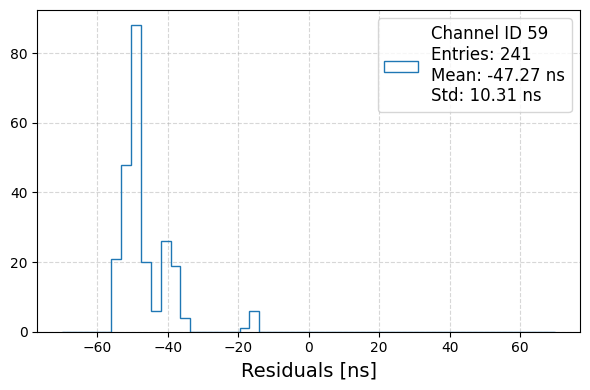

In [233]:
fig = plt.figure(dpi=100)

lab = "Channel ID "+str(selected_channel)+"\n"
lab += "Entries: {}\n".format(len(residuals))
lab += "Mean: {:.2f} ns\n".format(np.mean(residuals*1e3))
lab += "Std: {:.2f} ns".format(np.std(residuals*1e3))

plt.hist( residuals*1e3, bins=50, histtype='step',range=(-70,70), label=lab)
#plt.ylabel("# entries", fontsize=16)
plt.xlabel("Residuals [ns]", fontsize=14)
plt.tight_layout()
plt.grid(linestyle="dashed", alpha=0.5)
plt.legend(fontsize=12)
plt.savefig("figs/run{}_channel_{}_residuals_test.pdf".format(RUN,selected_channel),dpi=150)
plt.show()

In [ ]:
# Plotting full distribution 
fig = plt.figure(dpi=100)

rmin=-10
rmax=12
r=(rmin,rmax)
s=0.5
b=int((rmax-rmin)/s)

res = thisdfg.mean_residual_ns.to_numpy()

lab = "Run {}\nMean: {:.2f} ns\nStd: {:.2f} ns".format(RUN,np.mean(res),np.std(res))

plt.hist(res, bins=b, linewidth=2, range=r, histtype="step", label=lab)

plt.xlabel("Time residual [ns]")
plt.ylabel("# PMTs")
plt.legend()
plt.grid(linestyle="dashed", alpha=0.5)
plt.savefig("figs/run{}_residuals_test.png".format(RUN),dpi=100)
plt.show()

## Looking at slope

In [ ]:
slopes = meandf["slope"].values
len(slopes)

In [ ]:
fig = plt.figure(dpi=100)

plt.hist( slopes*1e3, bins=50, range=(-0.1,0.075), histtype='step')
plt.ylabel("# Flash-Track matches", fontsize=14)
plt.xlabel("Fitted slope [cm ns$^{-1}$]", fontsize=14)

plt.axvline(x=0.,color="red",linestyle="dotted")

#plt.tight_layout()
plt.grid(linestyle="dashed",alpha=0.5)
#plt.legend()
plt.savefig("figs/run{}_slope_distribution_test.png".format(RUN),dpi=100)
plt.show()


In [ ]:
rdf.head(7)